# Classification with Convolutional Neural Network using PyTorch

ในบทเรียนนี้เราจะทดลองสร้าง Convolutional Neural Network ซึ่งเป็น Neural Network ที่ใช้ฟีเจอร์เชิงพื้นที่ (spatial features) ของภาพเพื่อนำมาช่วยใช้ในการเทรนและทำนายประเภทของภาพ โดยในตัวอย่างนี้เราจะใช้ภาพที่เราได้ทดลองใช้ตอนเรียนเรื่อง Principal Component Analysis (PCA) ซึ่งเป็นภาพที่ผู้ป่วยทดลองวาดนาฬิกา มาทดลองสร้างโมเดลเพื่อแบ่งประเภทกัน

ชุดข้อมูล: https://github.com/cccnlab/CDT-API-Network

In [1]:
# Download the dataset which contrains images and labels
!wget -O images.pickle https://github.com/ichatnun/brainCodeCamp/raw/main/Fundamentals/DimensionalityReduction/data/CDT/clock_images.pickle
!wget -O labels.pickle https://github.com/ichatnun/brainCodeCamp/raw/main/Fundamentals/DimensionalityReduction/data/CDT/labels.pickle

--2023-05-30 02:21:03--  https://github.com/ichatnun/brainCodeCamp/raw/main/Fundamentals/DimensionalityReduction/data/CDT/clock_images.pickle
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ichatnun/brainCodeCamp/main/Fundamentals/DimensionalityReduction/data/CDT/clock_images.pickle [following]
--2023-05-30 02:21:03--  https://raw.githubusercontent.com/ichatnun/brainCodeCamp/main/Fundamentals/DimensionalityReduction/data/CDT/clock_images.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1106083 (1.1M) [application/octet-stream]
Saving to: 'images.pickle'

     0K .......... .......... .

In [2]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from glob import glob
from PIL import Image
from matplotlib import pyplot as plt
import pickle
import pandas as pd
import numpy as np
import os

### Prepare Data

การเตรียมข้อมูลทำได้โดยการอ่านข้อมูลภาพจาก `images.pickle` และประเภทของภาพจาก `labels.pickle` เพื่อใช้ในการเตรียมข้อมูล จากนั้นเปลี่ยนเป็น dataframe

In [3]:
with open("images.pickle", "rb") as handle:
    images = pickle.load(handle)
with open("labels.pickle", "rb") as handle:
    labels = pickle.load(handle)

In [4]:
list_images = []
for image in images:
    image = Image.fromarray(image)
    image = image.convert("RGB")  # Convert to RGB mode
    list_images.append(image)

สร้าง dataframe ที่เก็บข้อมูลที่จำเป็นต้องใช้ โดยมี column ดังนี้
- `Images` : ภาพที่ใช้ train
- `encoded_labels` : ค่า label โดย 0 คือ ปกติ และ 1 คือ ผิดปกติ

In [5]:
df_data = pd.DataFrame(columns=["Images", "encoded_labels"])

for img, label in zip(list_images, labels):
    df_data = df_data.append({"Images": img, "encoded_labels": label}, ignore_index=True)

<ipython-input-5-216431fcd8d8>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data = df_data.append({"Images": img, "encoded_labels": label}, ignore_index=True)
<ipython-input-5-216431fcd8d8>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data = df_data.append({"Images": img, "encoded_labels": label}, ignore_index=True)
<ipython-input-5-216431fcd8d8>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data = df_data.append({"Images": img, "encoded_labels": label}, ignore_index=True)
<ipython-input-5-216431fcd8d8>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data = df_data.append({"Images": img, "encoded_labels": label},

## เตรียมชุดข้อมูล (Prepare Data)

แบ่งข้อมูลเป็น train set (90%) และ test set (10%) โดยใช้ `train_test_split` จาก `sklearn.model_selection`

In [6]:
train_data, test_data = train_test_split(df_data, test_size=0.1, random_state=42)
len(train_data), len(test_data)

(54, 6)

สร้างชุดข้อมูล dataset จาก training และ testing โดยใช้ `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` โดย

- `Dataset` เป็น class ที่ใช้ในการกำหนดชุดข้อมูลของเรา โดยปกติจะประกอบด้วย 3 ฟังก์ชันหลักคือ `__init__` ใช้เพื่อประกาศค่าต่างๆ, `__len__` เป็นฟังก์ชันที่ให้ขนาดของชุดข้อมูล, และ `__getitem__` ที่มี index เป็น input และให้ `img` และ `label` ของ index นั้นๆออกมา
- `DataLoader` ส่วนมากจะใช้ร่วมกับ `Dataset` ที่เราสร้างขึ้น โดยเมื่อเราประกาศ `Dataset` แล้วจะสามารถนำ `DataLoader` มาครอบ `Dataset` เพื่อใช้ในการดึงข้อมูลออกมาเป็น batch ได้

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

base_path = "CDT_dataset"

class CDT_dataset(Dataset):
    def __init__(self, img_data, base_path, transform):
        self.img_data = img_data 
        self.base_path = base_path
        self.transform = transform

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, index):
        img = self.img_data.iloc[index]["Images"]
        img = img.resize((32, 32)) # ลดขนาดภาพให้มีขนาด 32x32 เพื่อใช้ในการทำนาย
        if self.transform is not None:
            img = self.transform(img)
        label = self.img_data.iloc[index]["encoded_labels"]
        return img, label


train_dataset = CDT_dataset(train_data, base_path, transform)
test_dataset = CDT_dataset(test_data, base_path, transform)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

เขียนฟังก์ชันเพื่อยกตัวอย่างภาพที่ใช้ train โดยใช้ `next(iter(train_loader))` เพื่อดึงตัวอย่างออกมา 1 batch ในด้านบนเรากำหนดให้ `batch_size` มีค่าเท่ากับ 4

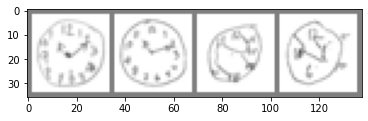

normal normal abnormal abnormal


In [9]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, labels = next(iter(train_loader))
SD_type = {0: "normal", 1: "abnormal"}

imshow(torchvision.utils.make_grid(images))
classes = ("normal", "abnormal")
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(4)))

## Training Model

สร้าง model โดยใช้ `torch.nn.Sequential` โดยมี layer ดังนี้
- Convolutional layer (`nn.Conv2d`) ซึ่งจะรับค่าทั้งหมด 3 ค่าคือ input depth, output depth และ kernel size ยกตัวอย่างเช่นในเลเยอร์แรก `nn.Conv2d(3, 6, 5)` จะรับ input depth ของภาพเท่ากับ 3 นั่นก็คือ RGB channel นั่นเอง และ output ออกมาเป็นภาพที่มี depth เท่ากับ 6
- จากนั้นก็จะส่งต่อไปให้ `nn.MaxPool2d(2, 2)` ซึ่งมี kernel size เท่ากับ 2 และ stride เท่ากับ 2 โดยจะลดขนาดของภาพเป็นครึ่งหนึ่งนั่นเอง (แต่ depth เท่าเดิม)

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net()

กำหนด `hyperparameters` ที่จำเป็นต้องใช้ ได้แก่ loss function ซึ่งคือ `CrossEntropyLoss`, optimizer ซึ่งคือ `Adam` ที่รับพารามิเตอร์ของโมเดล จากนั้นเทรนโมเดลโดยใส่ชุดข้อมูลเข้าไปในโมเดล และทำการอัพเดทโมเดลด้วยการคำนวณ  gradient (`loss.backward()`) และอัพเดทพารามิเตอร์ของโมเดล (`optimizer.step()`)

In [11]:
# Define a Loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 10 == 9:
            print(f"[epoch: {epoch + 1} ] loss: {running_loss / 1:.3f}")
            running_loss = 0.0

print("Finished Training")

[epoch: 1 ] loss: 22.926
[epoch: 2 ] loss: 9.787
[epoch: 3 ] loss: 7.052
[epoch: 4 ] loss: 7.463
[epoch: 5 ] loss: 7.127
[epoch: 6 ] loss: 7.052
[epoch: 7 ] loss: 6.864
[epoch: 8 ] loss: 7.052
[epoch: 9 ] loss: 7.088
[epoch: 10 ] loss: 7.005
[epoch: 11 ] loss: 6.977
[epoch: 12 ] loss: 7.308
[epoch: 13 ] loss: 6.862
[epoch: 14 ] loss: 6.846
[epoch: 15 ] loss: 6.977
[epoch: 16 ] loss: 7.246
[epoch: 17 ] loss: 6.921
[epoch: 18 ] loss: 7.170
[epoch: 19 ] loss: 7.069
[epoch: 20 ] loss: 6.585
[epoch: 21 ] loss: 6.996
[epoch: 22 ] loss: 6.520
[epoch: 23 ] loss: 5.816
[epoch: 24 ] loss: 3.796
[epoch: 25 ] loss: 2.211
[epoch: 26 ] loss: 1.867
[epoch: 27 ] loss: 0.460
[epoch: 28 ] loss: 0.661
[epoch: 29 ] loss: 0.334
[epoch: 30 ] loss: 0.162
[epoch: 31 ] loss: 0.041
[epoch: 32 ] loss: 0.142
[epoch: 33 ] loss: 0.041
[epoch: 34 ] loss: 0.009
[epoch: 35 ] loss: 0.008
[epoch: 36 ] loss: 0.012
[epoch: 37 ] loss: 0.008
[epoch: 38 ] loss: 0.007
[epoch: 39 ] loss: 0.005
[epoch: 40 ] loss: 0.005
[epoch: 

In [13]:
# Save the model
PATH = "./CDT_model.pth"
torch.save(model.state_dict(), PATH)

### Validation Data

ทดลองนำภาพตัวอย่างจาก test set มาทำนายด้วยโมเดลที่เราได้เทรนไป

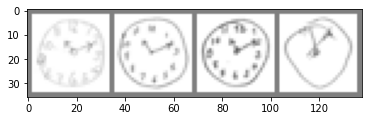

GroundTruth:  normal normal normal abnormal


In [14]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join(f"{classes[labels[j]]:5s}" for j in range(4)))

ในการใช้งานจริงเราสามารถสร้างโมเดล และอ่าน weights (หรือ parameters) ของโมเดลที่เทรนไว้แล้ว เพื่อนำมาใช้ทำนายเลยได้ ไม่จำเป็นต้องเทรนใหม่

In [15]:
model = Net()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [16]:
# Predictions
outputs = model(images)

_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join(f"{classes[predicted[j]]:5s}" for j in range(4)))

Predicted:  normal normal normal abnormal


ในตัวอย่างนี้เราเพียงแค่ต้องการโชว์กระบวนการเบื้องต้นของการสร้างและเทรนโมเดล Convolutional Neural Network เท่านั่นแต่ในเทรนโมเดลจริงนั่นเรายังต้องคำนึงถึงปัจจัยอื่นๆอีกมากมาย เช่น การ overfit ของโมเดล, การปรับหน้าตาของโมเดล, การใช้ optimizer แบบอื่นๆ ที่เป็นปัจจัยในการเทรนโมเดลให้มีประสิทธิภาพ